<a href="https://colab.research.google.com/github/im-ant/gym_RL/blob/master/DQN_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DQN

Following the tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

---

Environments
- Cartpole: https://github.com/openai/gym/wiki/CartPole-v0
  - "Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials."


In [0]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Get gym environment
env = gym.make('CartPole-v0').unwrapped

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
###################################################
# Replay memory module
#

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# Memory 
class ReplayMemory(object):
  
  def __init__(self, capacity):
    self.capacity = capacity
    self.memory = []
    self.position = 0
  
  def push(self, *args):
    """Saves a transition."""
    if len(self.memory) < self.capacity:
        self.memory.append(None)
    self.memory[self.position] = Transition(*args)
    self.position = (self.position + 1) % self.capacity # modulo delete
  
  def sample(self, batch_size):
    """Sample from stored memory"""
    return random.sample(self.memory, batch_size)
  
  def __len__(self):
    return len(self.memory)
  

In [0]:
###################################################
# DQN
#

class DQN(nn.Module):
  
  def __init__(self, observ_dim, hidden_dim, action_dim):
    super(DQN, self).__init__()
    
    self.observ_dim = observ_dim
    self.hidden_dim = hidden_dim
    self.action_dim = action_dim
    
    self.fc1 = nn.Linear(self.observ_dim, self.hidden_dim)
    self.bn1 = nn.BatchNorm1d(self.hidden_dim)
    
    self.fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
    self.bn2 = nn.BatchNorm1d(self.hidden_dim)
    #self.fc3 = nn.Linear(self.hidden_dim, self.hidden_dim)
    #self.bn3 = nn.BatchNorm1d(self.hidden_dim)
    
    self.fc4 = nn.Linear(self.hidden_dim, self.action_dim)
  
  # Forward pass
  def forward(self, x):
    
    h = F.relu(self.bn1(self.fc1(x)))
    h = F.relu(self.bn2(self.fc2(h)))
    #h = F.relu(self.bn3(self.fc3(h)))
    
    return self.fc4(h)
  

In [0]:
###################################################
# Agent methods (didn't put in class, but could)


# Training hyperparameters
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 200
TARGET_UPDATE = 250

LEARNING_RATE = 5e-4

MEMORY_SIZE = 1000000


# Action and observations
N_ACTIONS = env.action_space.n
N_OBSV = np.prod( env.observation_space.shape ) #hacky way to get input
N_HIDDEN = 8 # hidden layer neurons


## Initialize networks
policy_net = DQN(N_OBSV, N_HIDDEN, N_ACTIONS) #.to(device)
target_net = DQN(N_OBSV, N_HIDDEN, N_ACTIONS) #.to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval() #set target net to evaluation only mode (not training)

# Initialize memory
memory = ReplayMemory(MEMORY_SIZE)

# Optimization
#optimizer = optim.Adam(policy_net.parameters())
optimizer = optim.RMSprop(policy_net.parameters(), lr=LEARNING_RATE)




#####
# Policy
steps_done = 0

def select_action(state):
  """Select action using the e-greedy policy"""
  global steps_done
  sample = random.random()
  
  # Decaying epsilon
  eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                  math.exp(-1. * steps_done / EPS_DECAY)
  
  steps_done += 1
  
  # Select action
  if sample > eps_threshold:
    with torch.no_grad():
      policy_net.eval()
      # t.max(1) returns max value * indeces, [1] returns the index
      act_selected = policy_net(state).max(1)[1].view(1,1)
      policy_net.train()
      return act_selected
      
  else:
    return torch.tensor([[random.randrange(N_ACTIONS)]])

In [0]:
#####
# Training the Q network

def optimize_model():
  """Learns for one step via sampling a batch of memory"""
  
  # Skip if not enough memory
  if len(memory) < BATCH_SIZE:
    return -1.0
  
  # Else sample memory 
  mem_batch = memory.sample(BATCH_SIZE)
  # Convert batches of Transitions to Transitions of batch arrays
  # How it works: https://stackoverflow.com/a/19343/3343043
  batch = Transition(*zip(*mem_batch)) 
  
  # TODO: see tutorial to understand what's happening here
  # Compute a mask of non-final states and concatenate the batch elements
  # (a final state would've been the one after which simulation ended)
  non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
  non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
  state_batch = torch.cat(batch.state)
  action_batch = torch.cat(batch.action)
  reward_batch = torch.cat(batch.reward)
  
  
  # Get the time t state-action values
  state_action_values = policy_net(state_batch).gather(1, action_batch)
  
  # Compute the t+1 values
  next_state_values = torch.zeros(BATCH_SIZE)
  next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
  expected_state_action_values = (next_state_values * GAMMA) + reward_batch
  
  
  # Compute loss
  loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
  #loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))
  
  ## Optimization
  optimizer.zero_grad()
  loss.backward()
  for param in policy_net.parameters(): #gradient-clipping
      param.grad.data.clamp_(-1, 1)
  optimizer.step()
    
  if loss is not None:
    return loss
  else:
    return -1.0
  

In [31]:
###################################################
# Actual environmental interactions
#


N_EPISODES = 5000
Epis_print_mod = 250



##
# Function to modify reward
def modify_reward(r, cur_timestep, epis_end):
  """Modify reward if needed depending on task"""
  
  if cur_timestep >= 200:
    return 1.0
  if epis_end and cur_timestep < 195:
    return -1.0
  
  return r
  

# For plotting
perEpisode_reward = []
perEpisode_loss = []
perEpisode_duration = []


for i_epis in range(N_EPISODES):
  
  # Initialize environment and state
  state_orig = env.reset()
  state = torch.Tensor(state_orig).unsqueeze(0)
  
  cumulative_reward = 0.0
  cumulative_loss = 0.0
  
  
  # Start episode
  for t in count():
    # Perform action
    action = select_action(state)
    
    # Get feedback
    next_state_orig, reward_orig, done, info = env.step(action.item())
    # Transofmr next state to tensor
    if not done:
      next_state = torch.Tensor(next_state_orig).unsqueeze(0)
    else:
      next_state = None
    # Modify reward and transform to tensor
    reward_orig = modify_reward(reward_orig, t, done)
    reward = torch.Tensor([reward_orig])
        
    # Store to memory
    memory.push(state, action, next_state, reward)
        
    # Optimization (of target network)
    cur_loss = optimize_model()
    
    # Increment variables
    state = next_state
    cumulative_reward += reward
    cumulative_loss += cur_loss
    
    # termination
    if done:
      perEpisode_reward.append(cumulative_reward)
      perEpisode_loss.append(cumulative_loss/t)
      perEpisode_duration.append(t)
      
      if i_epis % Epis_print_mod == 0:
        print('Episode: %d | \t Reward: %f' % (i_epis+1, cumulative_reward) )
        
      cumulative_reward = 0.0
      cumulative_loss = 0.0
      break
      
  
  # Update target network
  if i_epis % TARGET_UPDATE == 0:
    target_net.load_state_dict(policy_net.state_dict())
    


Episode: 1 | 	 Reward: 8.000000
Episode: 251 | 	 Reward: 27.000000
Episode: 501 | 	 Reward: 9.000000
Episode: 751 | 	 Reward: 19.000000
Episode: 1001 | 	 Reward: 31.000000
Episode: 1251 | 	 Reward: 156.000000
Episode: 1501 | 	 Reward: 211.000000
Episode: 1751 | 	 Reward: 185.000000
Episode: 2001 | 	 Reward: 154.000000
Episode: 2251 | 	 Reward: 374.000000
Episode: 2501 | 	 Reward: 294.000000
Episode: 2751 | 	 Reward: 101.000000
Episode: 3001 | 	 Reward: 353.000000
Episode: 3251 | 	 Reward: 23.000000
Episode: 3501 | 	 Reward: 186.000000
Episode: 3751 | 	 Reward: 89.000000
Episode: 4001 | 	 Reward: 21.000000
Episode: 4251 | 	 Reward: 26.000000
Episode: 4501 | 	 Reward: 126.000000
Episode: 4751 | 	 Reward: 65.000000


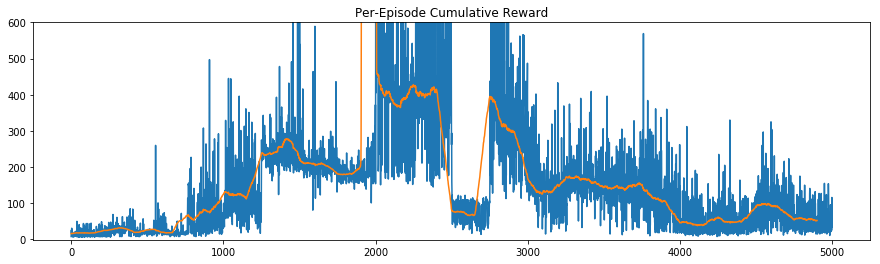

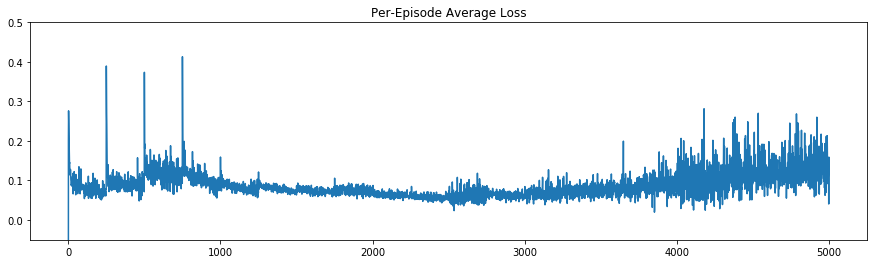

In [41]:
## Plot per episode cumulative reward
# Smooth over average
avg_perEpi_reward = np.convolve(perEpisode_reward, np.ones((100,))/100, mode='valid')

plt.figure(figsize=(15,4))
plt.plot(perEpisode_reward)
plt.plot(avg_perEpi_reward)
plt.ylim([-1, 600])
plt.title('Per-Episode Cumulative Reward')
plt.show()


## Plot per episode average network loss
plt.figure(figsize=(15,4))
plt.plot(perEpisode_loss)
plt.title('Per-Episode Average Loss')
plt.ylim([-0.05, 0.5])
plt.show()